In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import chainer.functions as F
import chainer.links as L
import chainerrl
import chainer
from gym import spaces

from arm import Arm

In [2]:
env=Arm(4,[1.,1.,1.,1])

In [3]:
##Q関数の定義
class QFunction(chainer.Chain):

    def __init__(self,obs_size,n_actions,n_hidden_channels=50):
        super().__init__()
        with self.init_scope():
            self.l0=L.Linear(obs_size,n_hidden_channels)
            self.l1=L.Linear(n_hidden_channels,n_hidden_channels*2)
            self.l2=L.Linear(n_hidden_channels*2,n_hidden_channels*2)
            self.l3=L.Linear(n_hidden_channels*2,n_actions)

    def __call__(self,x,test=False):
        h=F.tanh(self.l0(x))
        h=F.tanh(self.l1(h))
        h=F.tanh(self.l2(h))
        return chainerrl.action_value.DiscreteActionValue(self.l3(h))

In [4]:
obs_size=env.state.shape[0]
n_actions=env.actions.shape[0]
q_func=QFunction(obs_size,n_actions)
optimizer=chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)
gamma=0.95
explorer=chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.1,random_action_func=env.action_space_d.sample)
replay_buffer=chainerrl.replay_buffer.ReplayBuffer(capacity=10**6)
phi=lambda x:x.astype(np.float32,copy=False)
agent=chainerrl.agents.DoubleDQN(
    q_func,optimizer,replay_buffer,gamma,explorer,
    replay_start_size=500,update_interval=1,target_update_interval=100,phi=phi)


In [5]:
file="agent_"+str(300)
agent.load(file)

In [6]:
env=Arm(4,[1.,1.,1.,1])
#print('observation space:',env.state)
#print('action space:',env.actions)
obs=env.reset()
print()
#env.render()
#print('initial observation:',obs)

action=env.random_action()
#print(action)
state,r,done=env.step(action)
#print('next observation:',state)
#print('reward:',r)
print()
env.actions.shape[0]
for i in range(5):
    act=env.random_action()
    #print(act)
    state,r,done=env.step(act)

print(env.th)

print(env.forward())



[0.         0.00314159 0.00314159 0.00628319]
[[1.00000000e+00 0.00000000e+00]
 [1.99999507e+00 3.14158749e-03]
 [2.99997533e+00 9.42473145e-03]
 [3.99989637e+00 2.19907713e-02]]


In [10]:
env.reset()
pos=env.forward() #現在のポジション
position=pos.reshape(1,4,2)
print(env.goal)

t=0
done=False
while not done:
    action=agent.act(obs)
    obs,reward,done=env.step(action)
    #print(env.th)
    pos=env.forward() #現在のポジション
    pos=pos.reshape(1,4,2)
    position=np.concatenate([position,pos],0)
    print(reward)

    if t>1000:
        break
    t=t+1
    
print("finished")
print("##############################")
    


[-2.17374572 -2.17374572]
-42.7992385995874
-42.785467000043234
-42.77159354596452
-42.75761837427663
-42.743541622908864
-42.72936343079309
-42.71508393786233
-42.70070328504942
-42.6862216142856
-42.67163906849909
-42.65695579161377
-42.64217192854762
-42.62728762521141
-42.61230302850722
-42.59721828632695
-42.582033547550914
-42.566748962046375
-42.551364680666005
-42.53588085524647
-42.52029763860684
-42.50461518454719
-42.488833647847024
-42.47295318426372
-42.45697395053105
-42.4408961043576
-42.424719804425216
-42.40844521038745
-42.39207248286798
-42.37560178345902
-42.3590332747197
-42.3590332747197
-42.3590332747197
-42.3590332747197
-42.3590332747197
-42.3590332747197
-42.3590332747197
-42.3590332747197
-42.3590332747197
-42.3590332747197
-42.3590332747197
-42.34236712017454
-42.32560348431175
-42.32560348431175
-42.32560348431175
-42.308742532581626
-42.308742532581626
-42.308742532581626
-42.29178443139499
-42.29178443139499
-42.29178443139499
-42.274729348121426
-42.2747

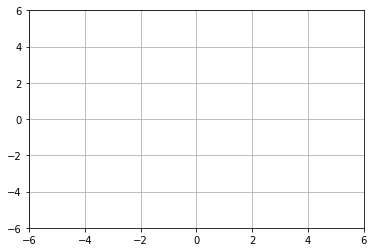

In [9]:
fig=plt.figure()
ax=fig.add_subplot(111,autoscale_on=False,xlim=(-6,6),ylim=(-6,6))
ax.grid()
line,=ax.plot([],[],'o-',lw=2)
linepath,=ax.plot([],[])
linepath1,=ax.plot([],[])
linepath2,=ax.plot([],[])
linepath3,=ax.plot([],[])

In [56]:
def init():
    line.set_data([],[])
    linepath.set_data([],[])
    linepath1.set_data([],[])
    linepath2.set_data([],[])
    linepath3.set_data([],[])
    
    return line,linepath,linepath1,linepath2

def animate(i):
    thisx=[0,position[i,0,0],position[i,1,0],position[i,2,0],position[i,3,0]] 
    thisy=[0,position[i,0,1],position[i,1,1],position[i,2,1],position[i,3,1]] 
    line.set_data(thisx,thisy)

    linepath.set_data(position[:i,3,0],position[:i,3,1])
    linepath1.set_data(position[:i,2,0],position[:i,2,1])
    linepath2.set_data(position[:i,1,0],position[:i,1,1])
    linepath3.set_data(position[:i,0,0],position[:i,0,1])
   

    return line,linepath,linepath1,linepath2
                    

In [57]:
length=position.shape[0]
ani=animation.FuncAnimation(fig,animate,np.arange(1,length),interval=30,blit=True,init_func=init)
ax.plot(env.goal[0],env.goal[1],marker='o',markersize=3,color='red')

plt.show()
ani.save("ik_by_rl.gif",writer='imagemagick',fps=50)

In [24]:
position[100,0,1]
#env.th

0.0

In [28]:
a=np.array([3,4,5,5,67,7])

In [19]:
a[:2]

NameError: name 'a' is not defined

In [35]:
range(1,5)

range(1, 5)

In [36]:
for i in range(1,5):
    print(i)

1
2
3
4
